Change the kernel to __newautoriftenv__.

In [13]:
import rasterio as rio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
from scipy.interpolate import interp2d

In [14]:
basepath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/Planet_test/'
os.listdir(basepath)

['PS_20190307_clipped.tif',
 '20190307_183151_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190304_201426_72_105f_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '.DS_Store',
 '20190307_183150_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190304_201430_83_105f_3B_AnalyticMS_SR_clip_5m_mv.tif',
 'PS_20190304_clipped.tif',
 '20190307_183149_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190307_183148_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif',
 '20190304_201428_77_105f_3B_AnalyticMS_SR_clip_5m_mv.tif',
 'PS_20190304.tif',
 '20190307_183152_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif',
 'PS_20190307.tif']

# Coregister and stitch all Planet tiles for each image date

In [15]:
# grab unique dates
filelist = os.listdir(basepath); filelist.sort()
unique_dates = []
for file in filelist:
    if file.startswith('2') and file.endswith('tif'):
        date = file[:8]
        unique_dates.append(date)
sorted_dates = list(set(unique_dates))
sorted_dates.sort()
print(sorted_dates)

['20190304', '20190307']


In [16]:
# Grab the first Planet tile for reference CRS and Transform
files = []
for file in filelist:
    if file.endswith('.tif'):
        files.append(file)
reftile = rio.open(basepath+files[0])
sr_ref = reftile.read(1)
print(reftile.crs)
reftile.transform

EPSG:32607


Affine(4.979215074031483, 0.0, 552405.7509554505,
       0.0, -4.97921507403153, 6675752.108247815)

In [17]:
for t in range(0, len(tiles)):
    plt.imshow(sr_coregistered[t],cmap='gray'); plt.colorbar(); plt.show()

NameError: name 'sr_coregistered' is not defined

TILES FOR 20190304
20190304_201426_72_105f_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.5170467581949132
20190304_201428_77_105f_3B_AnalyticMS_SR_clip_5m_mv.tif not corrrected. Grabbing original product.
Mean: 0.2752648123460929
20190304_201426_72_105f_3B_AnalyticMS_SR_clip_5m_mv.tif already corrected. Grabbing coregistered product.
Mean: 0.5170467581949132
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.24858177245110272
Smaller coregistered: 0.0002494837936505614
Larger: 0.2752648123460929


20190304_201430_83_105f_3B_AnalyticMS_SR_clip_5m_mv.tif not corrrected. Grabbing original product.
Mean: 0.2989969957584455
20190304_201428_77_105f_3B_AnalyticMS_SR_clip_5m_mv.tif already corrected. Grabbing coregistered product.
Mean: 0.2752648123460929
Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -0.044189078952336105
Smaller coregistered: 0.19295266294145091
Larger: 0.2310757333937566




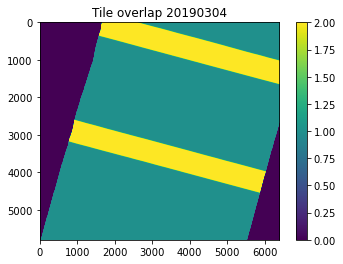

Overlapping tiles were coregistered.


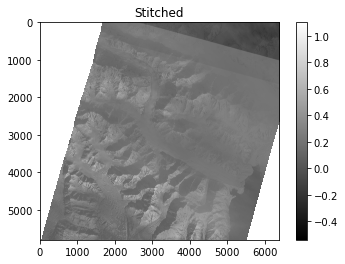

TILES FOR 20190307
20190307_183148_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif saved. Mean:  0.09124769338031394
20190307_183149_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif not corrrected. Grabbing original product.
Mean: 0.15569216389867238
20190307_183148_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif already corrected. Grabbing coregistered product.
Mean: 0.09124769338031394
Current tile is larger.
Mean difference in values from the larger tile in overlap area: 0.027386075867311076
Smaller coregistered: 0.12462341668761398
Larger: 0.15569216389867238


20190307_183150_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif not corrrected. Grabbing original product.
Mean: 0.16729166312781515
20190307_183149_0f33_3B_AnalyticMS_SR_clip_5m_mv.tif already corrected. Grabbing coregistered product.
Mean: 0.15569216389867238
Current tile is larger.
Mean difference in values from the larger tile in overlap area: -0.005211272554024094
Smaller coregistered: 0.12553690703168327
Larger: 0.16729166312781515


20190307_183151_0f33_3B_Analy

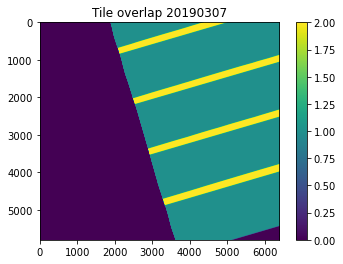

Overlapping tiles were coregistered.


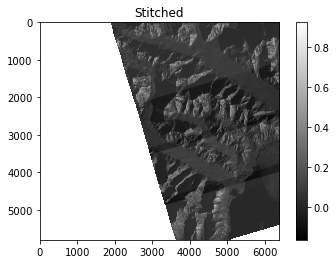

In [20]:
for date in sorted_dates:  
    print('TILES FOR '+date)
    # Grab the Planet tiles corresponding to each unique date
    tiles = []
    for file in filelist:
        if file.startswith(date) and file.endswith('.tif'):
            tiles.append(file)
    tiles.sort() # sort tilenames alphanumeric order
    
    # initialize empty arrays
    overlap_total = np.zeros(sr_ref.shape); total_coverage = np.zeros(sr_ref.shape).astype(bool)
    sr_originals = np.zeros((len(tiles),sr_ref.shape[0],sr_ref.shape[1]))
    sr_coregistered = np.zeros((len(tiles),sr_ref.shape[0],sr_ref.shape[1]))
    sr_binary = np.zeros((len(tiles),sr_ref.shape[0],sr_ref.shape[1]))
    
    # For each date's tiles
    for t in range(0, len(tiles)):
        tile = tiles[t] 
        
        if t == 0: # for first tile, read in the original
            reader = rio.open(basepath+tile); sr = reader.read(1) 
            sr_orig = sr.copy(); sr_originals[t] = sr_orig # store the original tile
            sr[sr>0] = 1 ; sr[np.isnan(sr)] = 0 # make tile binary
            
            sr_data = sr_orig # use the original tile as the data
            sr_coregistered[t] = sr_data # skip coregistration
            sr_binary[t] = sr # save binary sr

            # use binary mask to calculate overlap area
            overlap_total = overlap_total+sr # add to calculate overlap
            tilesize = np.count_nonzero(sr) # grab the current tile size (pixels)
            overlap_area = np.count_nonzero(overlap_total[overlap_total >= 2]) # total overlap area
            
            print(tile, 'saved. Mean: ',np.nanmean(sr_data)); # Plot!
#             plt.imshow(sr_orig,cmap='gray'); plt.title('Tile'); plt.colorbar(); plt.show()
    
        elif t >= 1: # start comparisons with the second tile
            prev_tile = tiles[t-1] # grab previous tile name
            
            # if the current tile has already been through coregistration or binary sr already saved,
            if np.count_nonzero(sr_coregistered[t]) > 0:
                print(tile,' already corrected. Grabbing that product.')
                sr = sr_binary[t] # grab the binary sr saved from before
                sr_data = sr_coregistered[t] # grab the coregistered tile saved from before
            else: # if not, read the original
                print(tile,'not corrrected. Grabbing original product.')
                reader = rio.open(basepath+tile); sr = reader.read(1) 
                sr_orig = sr.copy(); sr_originals[t] = sr_orig # store the original tile
                sr_data = sr_orig # use the original tile
                sr[sr>0] = 1 ; sr[np.isnan(sr)] = 0 # make tile binary
                sr_binary[t] = sr # save the binary sr
            print('Mean:',np.nanmean(sr_data))
                   
            # if previous tile has already been through coregistration or binary sr already saved,
            if np.count_nonzero(sr_coregistered[t-1]) > 0:
                print(prev_tile,'already corrected. Grabbing coregistered product.')
                sr_prev = sr_binary[t-1] # grab the binary sr saved from before
                sr_data_prev = sr_coregistered[t-1] # grab the coregistered tile saved from before
            else: # if not, read the original
                print(prev_tile,'not coregistered. Grabbing original product.')
                reader = rio.open(basepath+prev_tile); sr_prev = reader.read(1) 
                sr_orig = sr_prev.copy(); sr_originals[t-1] = sr_orig # store the original tile
                sr_data_prev = sr_orig # use the original tile
                sr_prev[sr_prev>0] = 1 ; sr_prev[np.isnan(sr_prev)] = 0 # make tile binary
                sr_binary[t-1] = sr_prev # save the binary sr
                sr_originals[t-1] = sr_orig # save the original tile
            print('Mean:',np.nanmean(sr_data_prev))
                
#             fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5)) # Plot!
#             im1 = ax1.imshow(sr_data_prev,cmap='gray'); ax1.set_title('Previous tile'); fig.colorbar(im1, ax=ax1)
#             im2 = ax2.imshow(sr_data,cmap='gray'); ax2.set_title('Tile'); fig.colorbar(im2, ax=ax2); plt.show()
            
            # use binary mask to calculate overlap area between the two
            overlap_total = overlap_total+sr # add to calculate overlap
            tilesize = np.count_nonzero(sr) # grab the current tile size (pixels)
            overlap_area = np.count_nonzero(overlap_total[overlap_total >= 2]) # total overlap area
            
            # Determine each pair of tiles' overlap
            if overlap_area > prev_overlap: # increase in overlapping area indicates we have 2 overlapping tiles!!!
                overlap2 = sr_prev+sr # calculate the overlap between just these two
                overlap_band = ma.masked_less(overlap2, 2) # mask out non-overlapping area
                overlap_band_mask = ma.getmaskarray(overlap_band) # grab the mask for the overlapping area
                
                # grab the current coverage of the 2 tiles
                combined_coverage = ma.masked_greater_equal(overlap2, 1) # get rid of anything less than 1
                coverage_mask = ma.getmaskarray(combined_coverage) # grab the mask
            
                # identify which tile is larger
                if tilesize > prev_tilesize:
                    print('Current tile is larger.')
                    larger_tile = sr_data; smaller_tile = sr_data_prev # assign the tiles
                    lt_idx = t; st_idx = t-1 # assign the indices
                elif tilesize < prev_tilesize:
                    print('Previous tile is larger.')
                    larger_tile = sr_data_prev; smaller_tile = sr_data # assign the tiles
                    lt_idx = t-1; st_idx = t # assign the indices
                else: # equal sizes
                    print('Tiles are the same size.')
                    larger_tile = sr_data; smaller_tile = sr_data_prev # use current tile to coregister
                    lt_idx = t; st_idx = t-1 # assign the indices
                    
                # grab pixel values from overlapping area from both tiles
                overlap_values_larger = ma.masked_where(overlap_band_mask, larger_tile)
                overlap_values_smaller = ma.masked_where(overlap_band_mask, smaller_tile)
                mean_diff = np.nanmean(np.subtract(overlap_values_larger,overlap_values_smaller)) # mean diff
                print('Mean difference in values from the larger tile in overlap area:',mean_diff)

                # coregister all other existing tile's values using the mean diff
                for et in range(0, len(tiles)):
                    if np.count_nonzero(sr_coregistered[et]) > 0: # if it exists
                        sr_coregistered[et] = sr_coregistered[et] + mean_diff
                # replace the small tile
                smaller_tile_coreg = smaller_tile + mean_diff # add the mean difference to all values
                smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile_coreg) 
                
                # with overlap removed:
                masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data 
                masked_larger_tile = larger_tile # skip masking
                print('Smaller coregistered:',np.nanmean(masked_smaller_tile_coreg))
                print('Larger:',np.nanmean(larger_tile))
                print(); print();
                
                # overwrite the two tiles used in comparison
                sr_coregistered[lt_idx] = masked_larger_tile
                sr_coregistered[st_idx] = masked_smaller_tile_coreg
                
#                # only keep part of the tiles that haven't been covered before 
#                 if np.count_nonzero(sr_coregistered[lt_idx]) > 0: # if we need to overwrite the larger tile
#                     masked_larger_tile = larger_tile # skip masking by previous cover
#                 else:
#                     larger_tile = ma.masked_where(total_coverage,larger_tile)
#                     masked_larger_tile = ~larger_tile.mask*larger_tile.data
#                 if np.count_nonzero(sr_coregistered[st_idx]) > 0: # if we need to overwrite the smaller tile
#                     masked_smaller_tile = smaller_tile # skip masking by previous cover
#                 else:
#                     smaller_tile_coreg = ma.masked_where(total_coverage, smaller_tile_coreg)
#                     masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
    
#                 # only write if blank (don't overwrite)
#                 if np.count_nonzero(sr_coregistered[lt_idx]) == 0:
#                     sr_coregistered[lt_idx] = masked_larger_tile
#                 if np.count_nonzero(sr_coregistered[st_idx]) == 0:
#                     sr_coregistered[st_idx] = masked_smaller_tile_coreg
                total_coverage = ma.mask_or(total_coverage, coverage_mask) # add to coverage to total coverage
            
        # Store tile info for the next round of comparison
        prev_overlap = overlap_area # amount of pixels overlapping
        prev_tilesize = tilesize # previous tile size (pixels w/ data)
        
    # Evaluate overlap between between all scenes
    fig = plt.figure(); im = plt.imshow(overlap_total); fig.colorbar(im); plt.title('Tile overlap '+date); plt.show()
    total_overlap_area = np.count_nonzero(overlap_total[overlap_total >= 2]) # overlapping areas will have >= 2
    stitched = np.zeros(sr.shape) # intialize stitched array
    if total_overlap_area > 0: # if there was overlap
        print('Overlapping tiles were coregistered.')
        stitched = np.nansum(sr_coregistered,0) # sum all coregistered (along slices)
    else: # if no overlap between any of the tiles
        stitched = np.nansum(sr_originals,0) # sum all (along slces)
    stitched[stitched == 0]=np.NaN # fill in with NaNs
    fig = plt.figure(); im = plt.imshow(stitched, cmap='gray'); plt.title('Stitched'); fig.colorbar(im); plt.show()
    
    # Export stitched image
    outfilename = 'PS_'+date+'.tif'
    with rio.open(basepath+outfilename,'w',
                      driver='GTiff',
                      height=stitched.shape[0], # new shape
                      width=stitched.shape[1], # new shape
                      dtype=stitched.dtype, # data type
                      count=1,
                      crs=reftile.crs, # the EPSG from the original DEM
                      transform=reftile.transform) as dst:
            dst.write(stitched, 1)
            
#     break
    del sr_coregistered; del sr_originals; del total_coverage; del overlap_total; del sr_binary;
    

In [19]:
sr_coregistered

nan

# Crop images to Turner Glacier's box

In [228]:
boxpath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/BoxTurner_UTM_07.shp' # path to shapefile

# clip all stitched files
for file in os.listdir(basepath):
    if file.startswith('PS') and file.endswith('.tif') and 'clipped' not in file:
        date = file[3:11]; print(date)
        
        # if the clipped version doesn't already exist
        if not file[:-4]+'_clipped.tif' in os.listdir(basepath): 
#             print(file)
            # Crop file
            crop_cmd = 'gdalwarp -cutline '+boxpath+' -crop_to_cutline '
            crop_cmd += basepath+file+' '+basepath+file[:-4]+'_clipped.tif'
            print(crop_cmd); print()

            subprocess.run(crop_cmd,shell=True,check=True); print()


20190304
20190307
